# Inaugural Project - Time Use of Couples

In this project we consider a household with a male and female member. We seek to investigate how the home production for men and women changes for different values for $\alpha$ and $\sigma$ and how it depends on the wages for men and women.
At last, we investigate a model by Siminski and Yetsenga (2022). 

**The structure of this inaugural project:**
1. Investigates how the fraction home production changes for men and women for different values of $\alpha$ and $\sigma$ when choice set is **discrete**
2. Investigates how the fraction of home production against wages for men and women changes for different values of $w_F$ when choice set is **discrete** 
3. Investigates how the fraction of home production against wages for men and women changes for different values of $w_F$ when choice set is **continuous** 
4. Seeks to minimize the loss in the model by Siminski and Yetsenga (2022)
5. Extension of the model (assuming a gender wage gap), and assuming men and women are equally productive in home production ($\alpha = 0.5$)



Imports and set magics:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ipywidgets as widgets
from scipy import optimize
import scipy.stats as stats

# Import our class
from HouseholdSpecializationModel import HouseholdSpecializationModelClass 

# Question 1

Choice set is discrete in half hours. We want to see how the $\frac{H_F}{H_M}$ ratio for different values of $\alpha$ and $\sigma$ changes. We construct a table with the combination of the possible 9 values.

In [2]:
# a. Importing class 
from HouseholdSpecializationModel import HouseholdSpecializationModelClass as HC

# b. Parameter values 
alpha = [0.25, 0.50, 0.75]
sigma = [0.50, 1.00, 1.50]

# c. Calls the functions/classes 
function = HC() 

# d. Creates a table for alpha and sigma
def print_table(alpha, sigma): 
    
    # i. Empty text
    text = ''
    
    # ii. Top header
    text += f'{"Combinations of alpha and sigma":3s}'
    text += '\n'
    for j, HF in enumerate(sigma):
       text += f'{j:6d}' 
    text += '\n'
    
    # iii. Body
    for i, a in enumerate(alpha):
        if i > 0:
            text += '\n' 
        text += f'{i:3d} '
        for j, s in enumerate(sigma):
            function.par.alpha = a
            function.par.sigma = s
            HM = function.solve_discrete().HM
            HF = function.solve_discrete().HF
            text += f'{HF/HM:6.3f}'
    
    # iv. Print
    print(text)

print_table(alpha,sigma)

/Users/idamariekroghjensen/Desktop/projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Desktop/projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Desktop/projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:66: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


Combinations of alpha and sigma
     0     1     2
  0  0.545 0.308 0.214
  1  1.000 1.000 1.000
  2  1.833 3.250 4.667


**Conclusion:**

Table 1 above indicates, that when $\alpha$ increases, the ratio between hours working at home for male and female increase. However, if $\sigma$ increases, the ratio between hours working at home for male and female decreases for $\alpha$ values at 0.25 and 0.50, but when $\alpha = 0.75$ the ratio will increase. 

# Question 2

Choice set is still discrete in half hours. 
We now want to construct a plot for the log of hours working at home and log of wages for men and women for different values of women's wages.

Note that since we know that $w_M$ is equal to 1 and therefore numeraire, we know that we can take $log(w_F)$ instead of $log(\frac{w_F}{w_M})$.

In [3]:
# a. Importing class 
from HouseholdSpecializationModel import HouseholdSpecializationModelClass as HC

# b. Calls the functions/classes 
function = HC() 

# c. Creating an empty list to store the results 
solution_wage = []

HM_wage_vec = ()
HF_wage_vec = ()
wF = (0.8, 0.9, 1.0, 1.1, 1.2)

# d. For loop
for wages in wF:
    function.par.wF = wages
    solution_wage.append(function.solve_discrete())

# e. Extracting results
HF_wage_vec = [ns.HF for ns in solution_wage]
HM_wage_vec = [ns.HM for ns in solution_wage]

H_ratio = [np.log(HF_ny/HM_ny) for HF_ny,HM_ny in zip(HF_wage_vec,HM_wage_vec)]
w_ratio = np.log(wF)

# f. Print
print(H_ratio)
print(w_ratio)


[0.22314355131420976, 0.0, 0.0, -0.11778303565638351, -0.2231435513142097]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


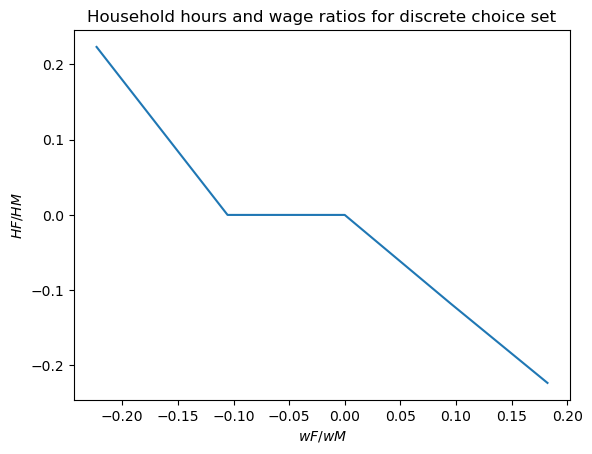

In [4]:
# a. Creating the figure
def plot_ratio():
    fig = plt.figure()

    # i. Create the plot
    ax = fig.add_subplot(1,1,1) 

    ax.plot(w_ratio,H_ratio)

    # ii. Add labels
    ax.set_title('Household hours and wage ratios for discrete choice set')
    ax.set_xlabel('$wF/wM$')
    ax.set_ylabel('$HF/HM$')

# b. Print
plot_ratio()

**Conclusion:**

From the plot above we see that when $w_F$ is increasing, the $log(\frac{H_F}{H_M})$ is decreasing, but when $w_F$ is between -0.10 and 0.10 the $log(\frac{H_F}{H_M})$ will be equal to 0.0. 

# Question 3

We now look at the same situation as above but now the time is **continuous** instead of discrete. 

The same conditions apply for $w_M$ and $w_F$.

We use the SLSQP-method when we optimize.

In [5]:
# a. Creating an empty list to store the results 
solution_con = []

# b. Values for female wage 
wF = (0.8, 0.9, 1.0, 1.1, 1.2)

# c. For loop
for wages in wF:
    function_1 = HouseholdSpecializationModelClass()
    function_1.par.wF = wages
    solution_con.append(function_1.solve_con())

# d. Extracting results
HF_wage_vec_con = [ns[3] for ns in solution_con]
HM_wage_vec_con = [ns[2] for ns in solution_con]

H_ratio_con = [np.log(HF_a/HM_a) for HF_a, HM_a in zip(HF_wage_vec_con,HM_wage_vec_con)]
w_ratio_con = np.log(wF)

# e. Print
print(H_ratio_con)
print(w_ratio_con)


/Users/idamariekroghjensen/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


[0.2231435449294482, 0.10536049861931081, 1.233154193371349e-08, -0.09531014063967057, -0.18232156745667802]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


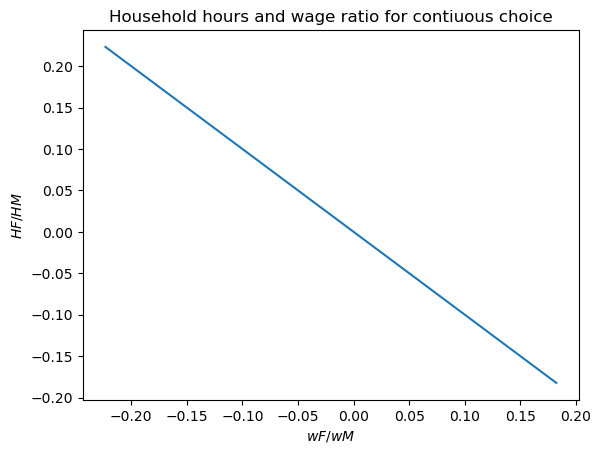

In [6]:
# a. Creating the figure
def plot_cont():
    fig = plt.figure()

    # i. Create the plot
    ax = fig.add_subplot(1,1,1) 

    ax.plot(w_ratio_con,H_ratio_con)

    # ii. Add labels
    ax.set_title('Household hours and wage ratio for contiuous choice')
    ax.set_xlabel('$wF/wM$')
    ax.set_ylabel('$HF/HM$')

# b. Print
plot_cont()

**Conclusion:**

The figure illustrates that when $w_F$ increases, the ratio between $log(\frac{H_F}{H_M})$ decreases.

# Question 4

We seek to find the values of $\alpha$ and $\sigma$ that minimizes $(\beta_0 - \hat\beta_0)^2 + (\beta_1 - \hat\beta_1)^2$.

As Siminski and Yetsenga (2022) finds, we set $\beta_0 \approx 0.4$ and $\beta_1 \approx -0.1$. 


$w_M$ will still be equal to 1 and $w_F$ will be in the interval 0.8 to 1.2.

We use the Nelder-Mead method when we optimize.


In [7]:
# a. Calls the functions/classes 
function_4 = HouseholdSpecializationModelClass()

# b. Estimates the optimal alpha and sigma 
min_parameters = function_4.estimate()

function_4.sol.beta0, function_4.sol.beta1


/Users/idamariekroghjensen/Desktop/projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Desktop/projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: overflow encountered in double_scalars
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/idamariekroghjensen/Desktop/projects-2023-julie-ida-ida-1/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: invalid value encountered in double_scalars
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


 optimal alpha = 0.9820137794792236
 optimal sigma = 0.1000000156595364


(0.40000000831497984, -0.10000002316416667)

We will now illustrate how the model by Siminski and Yetsenga (2022) fit the data. 

Text(0, 0.5, 'log(HF/HM)')

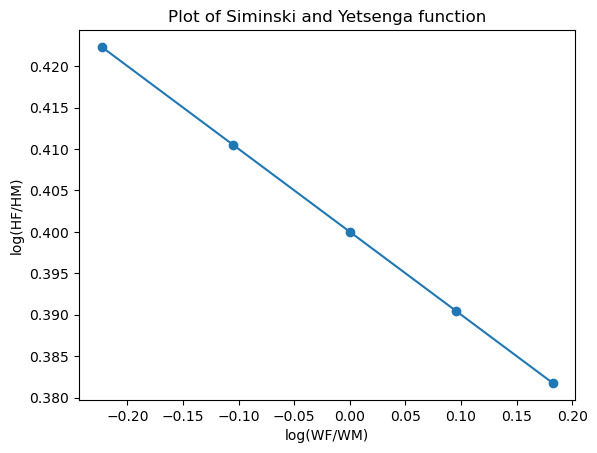

In [8]:
# a. Creating the plot
fig = plt.figure()
ax4 = fig.add_subplot(1,1,1)

# b. Plot data of log ratio W and log ratio H
log_wF_vec = np.log(function_4.par.wF_vec)
log_H_vec = np.log(function_4.sol.HF_vec/function_4.sol.HM_vec)
ax4.scatter(log_wF_vec, log_H_vec)

# c. Defining the Siminski and Yetsenga function 
func_4 = function_4.sol.beta0 + function_4.sol.beta1*log_wF_vec

# d. Plotting
plt.plot(log_wF_vec, func_4)
ax4.set_title('Plot of Siminski and Yetsenga function')
ax4.set_xlabel('log(WF/WM)')
ax4.set_ylabel('log(HF/HM)')

**Conclusion:**

It means that when $\alpha = 0.98$ and $\sigma = 0.1$ it minimizes $(\beta_0 - \hat\beta_0)^2 + (\beta_1 - \hat\beta_1)^2$ such that $\beta_0 \approx 0.4$ and $\beta_1 \approx -0.1$ as in the model by Siminski and Yetsenga.

$\sigma$ is defined as the elasticity of substitution. Since we find a low $\sigma = 0.1$, this means that the substitution between working in the market and working in the home is low. 

Furthermore, we find that $\alpha = 0.98$. $\frac{\alpha}{1-\alpha}$ is defined as the productivity in the home production for females relative to males. Given that we find a high value for $\alpha$, this means that the productivity in the home is relatively high for females compared to men.

Overall the values of $\alpha$ and $\sigma$ we find, which minimizes the expression, are consistent with what we expect to find. 

# Question 5

We are now going to extent the model. We will assume that there is a gender wage gap, described by $\kappa$. $\kappa$ shows how much women earn when men earn 1 unit. The consumption for market goods therefore become: 
$$
C = w_ML_M + \kappa w_FL_F
$$

Our baseline parameters now change, such that $w_M \neq w_F$.

Furthermore, it is assumed that men and women are equally productive in home production ($\alpha = 0.5$). 

In [9]:
# a. Importing class 
from HouseholdSpecializationModel import HouseholdSpecializationModelClass_5 as HC_5

# b. Calls the functions/classes
function_5 = HC_5() 

# c. Finds the estimates for the betas when alpha = 0.5 and kappa 0.8
min_parameters = function_5.estimate()

function_5.sol.beta0, function_5.sol.beta1


 optimal alpha = 0.5
 optimal kappa = 0.8


(0.22314355219194165, -1.0000001014310267)

**Conclusion:**

When men and women are equally productive in home production and women earn 80 pct. of what men earn, the estimates for $\beta_0 = 0.22$ and $\beta_1 = -1.00$. Both estimates are further away from the model by Siminski and Yetsenga (2022) in the extented model where men and women are equally productive in home production. This is in line with our previous results, where we found the optimal $\alpha$ to be 0.98 for $\beta_0 = 0.4$ and $\beta_1 = -0.1$. So for the model to fit data, $\alpha$ should be 0.98. 